# Training Poisson's Equation Encoder

Here is a demonstration on how to train the encoder to learn the parameters $\theta$ of
a partial differential equation (PDE) given observations of the solution $u_\theta$.
Now, technically for this procedure we don't actually need $u_\theta$ to be the solution of a PDE,
it just needs to be some family of functions parameterized by $\theta$.
But we will consider the PDE setting, as it is the desired usage of this autoencoder.

To that end, let $\theta = (c, b_0, b_1)$ be (constant) parameters for the Poisson equation
with Dirichlet boundary conditions on the unit interval. That is, $u_\theta$ is the solution to

$$
\begin{align*}
    -\Delta u &= c \quad\text{on}\quad [0,1] \\
    u(0) &= b_0 \\
    u(1) &= b_1
\end{align*}
$$

Since $c$ is constant, this equation is readily solved for $u_\theta = u(x)$ as the family of parabolas

$$ 
    u(x) = -\frac{c}{2} x^2 + \left( \frac{c}{2} + b_1 - b_0 \right) x + b_0 
$$

Now we will walk through training the encoder in five main steps:
1. Write the configuration file
2. Load the data
3. Design the neural network
4. Train the network
5. Assess model fit

## 1. Poisson configuration file
To train the encoder to learn $\theta$, 
we simply create a Python script `equations/poisson.py`
which contains the implementations of functions that define the domain, compute replicates of $\theta$,
compute $u_\theta$ for a given replicate, and a list of parameter names (optional). 
There is a template configuration file in the `equations` directory.
Let's briefly walk through the Poisson configuration file.

### Parameter names
First we import `numpy` and create a list containing strings to name the parameters in $\theta$.
In this case the names are $c$, $b_0$, and $b_1$.
The strings may be formatted with `matplotlib`'s TeX rendering syntax.

In [1]:
import numpy as np 

# PARAMETER NAMES
theta_names = [r'$c$', r'$b_0$', r'$b_1$']

### Domain lattice
Next we write a quick function that computes a lattice over the domain,
in this case the unit interval.

In [2]:
# DOMAIN
def domain():
    """
    The unit interval as an array of length 100
    """
    return np.linspace(0., 1., num=100)

### Solution $u_\theta$
Now we write a function that takes $\theta$ as the input,
and computes the solution function $u_\theta = u(x)$ over
the lattice defined above.
This should be written assuming the argument `theta` is 
a one-dimensional numpy array that contains the parameter values.

In [3]:
# SOLUTION
def solution(theta):
    """
    Computes the solution u where theta=[c, b0, b1]
    """
    x = domain()
    c = theta[0]
    b0 = theta[1]
    b1 = theta[2]
    u = -c * x**2 / 2 + (c/2 + b1 - b0)*x + b0
    return u

### Priors on $\theta$
Now to simulate replicates of our parameters,
we draw from uniform distributions and stack the arrays
so that the output has shape `(replicates, num_params)`.

In [4]:
# THETA
def theta(replicates):
    """
    Simulates replicates of Theta
    Output has shape (replicates, num_params)
    """
    # create replicates of theta=[c, b0, b1]
    c = np.random.uniform(-100,100, size=replicates)
    b0 = np.random.uniform(-10,10, size=replicates)
    b1 = np.random.uniform(-10,10, size=replicates)
    theta = np.stack((c, b0, b1), axis=1)
    return theta

With `equations/poisson.py` properly configured we need only run
`python train_encoder.py --trainon poisson`.
The file `train_encoder.py` has three main parts to it: 
load data, define neural network hyperparameters, train model.
Instead of running this script, let's break it down here.

## 2. Load data
The modules loaded in `train_encoder.py` are in the `Poisson` package.
We load (and possibly simulate) data using the 
`Poisson.equation.Dataset` class,
which simply needs the name of the configuration file, excluding the file suffix.

In [5]:
from Poisson.equation import Dataset

# LOAD DATA
dataset = Dataset('poisson')
dataset.load()

The data are now loaded into the Dataset instance `dataset`,
already split into a training, validation, and test set.
It loads the data from the pickled file `data/poisson.pkl`,
but if the file doesn't exist the data are simulated
according to the configuration file using a default of 2000 replicates.
The parameter names and functions defined in the configuration file
are loaded and stored in the `Dataset` class.
We can use this to explore the data before designing the network.
Observe, we'll plot $u_\theta = u(x)$ for two realizations of $\theta$,
with the parameter values in the titles.

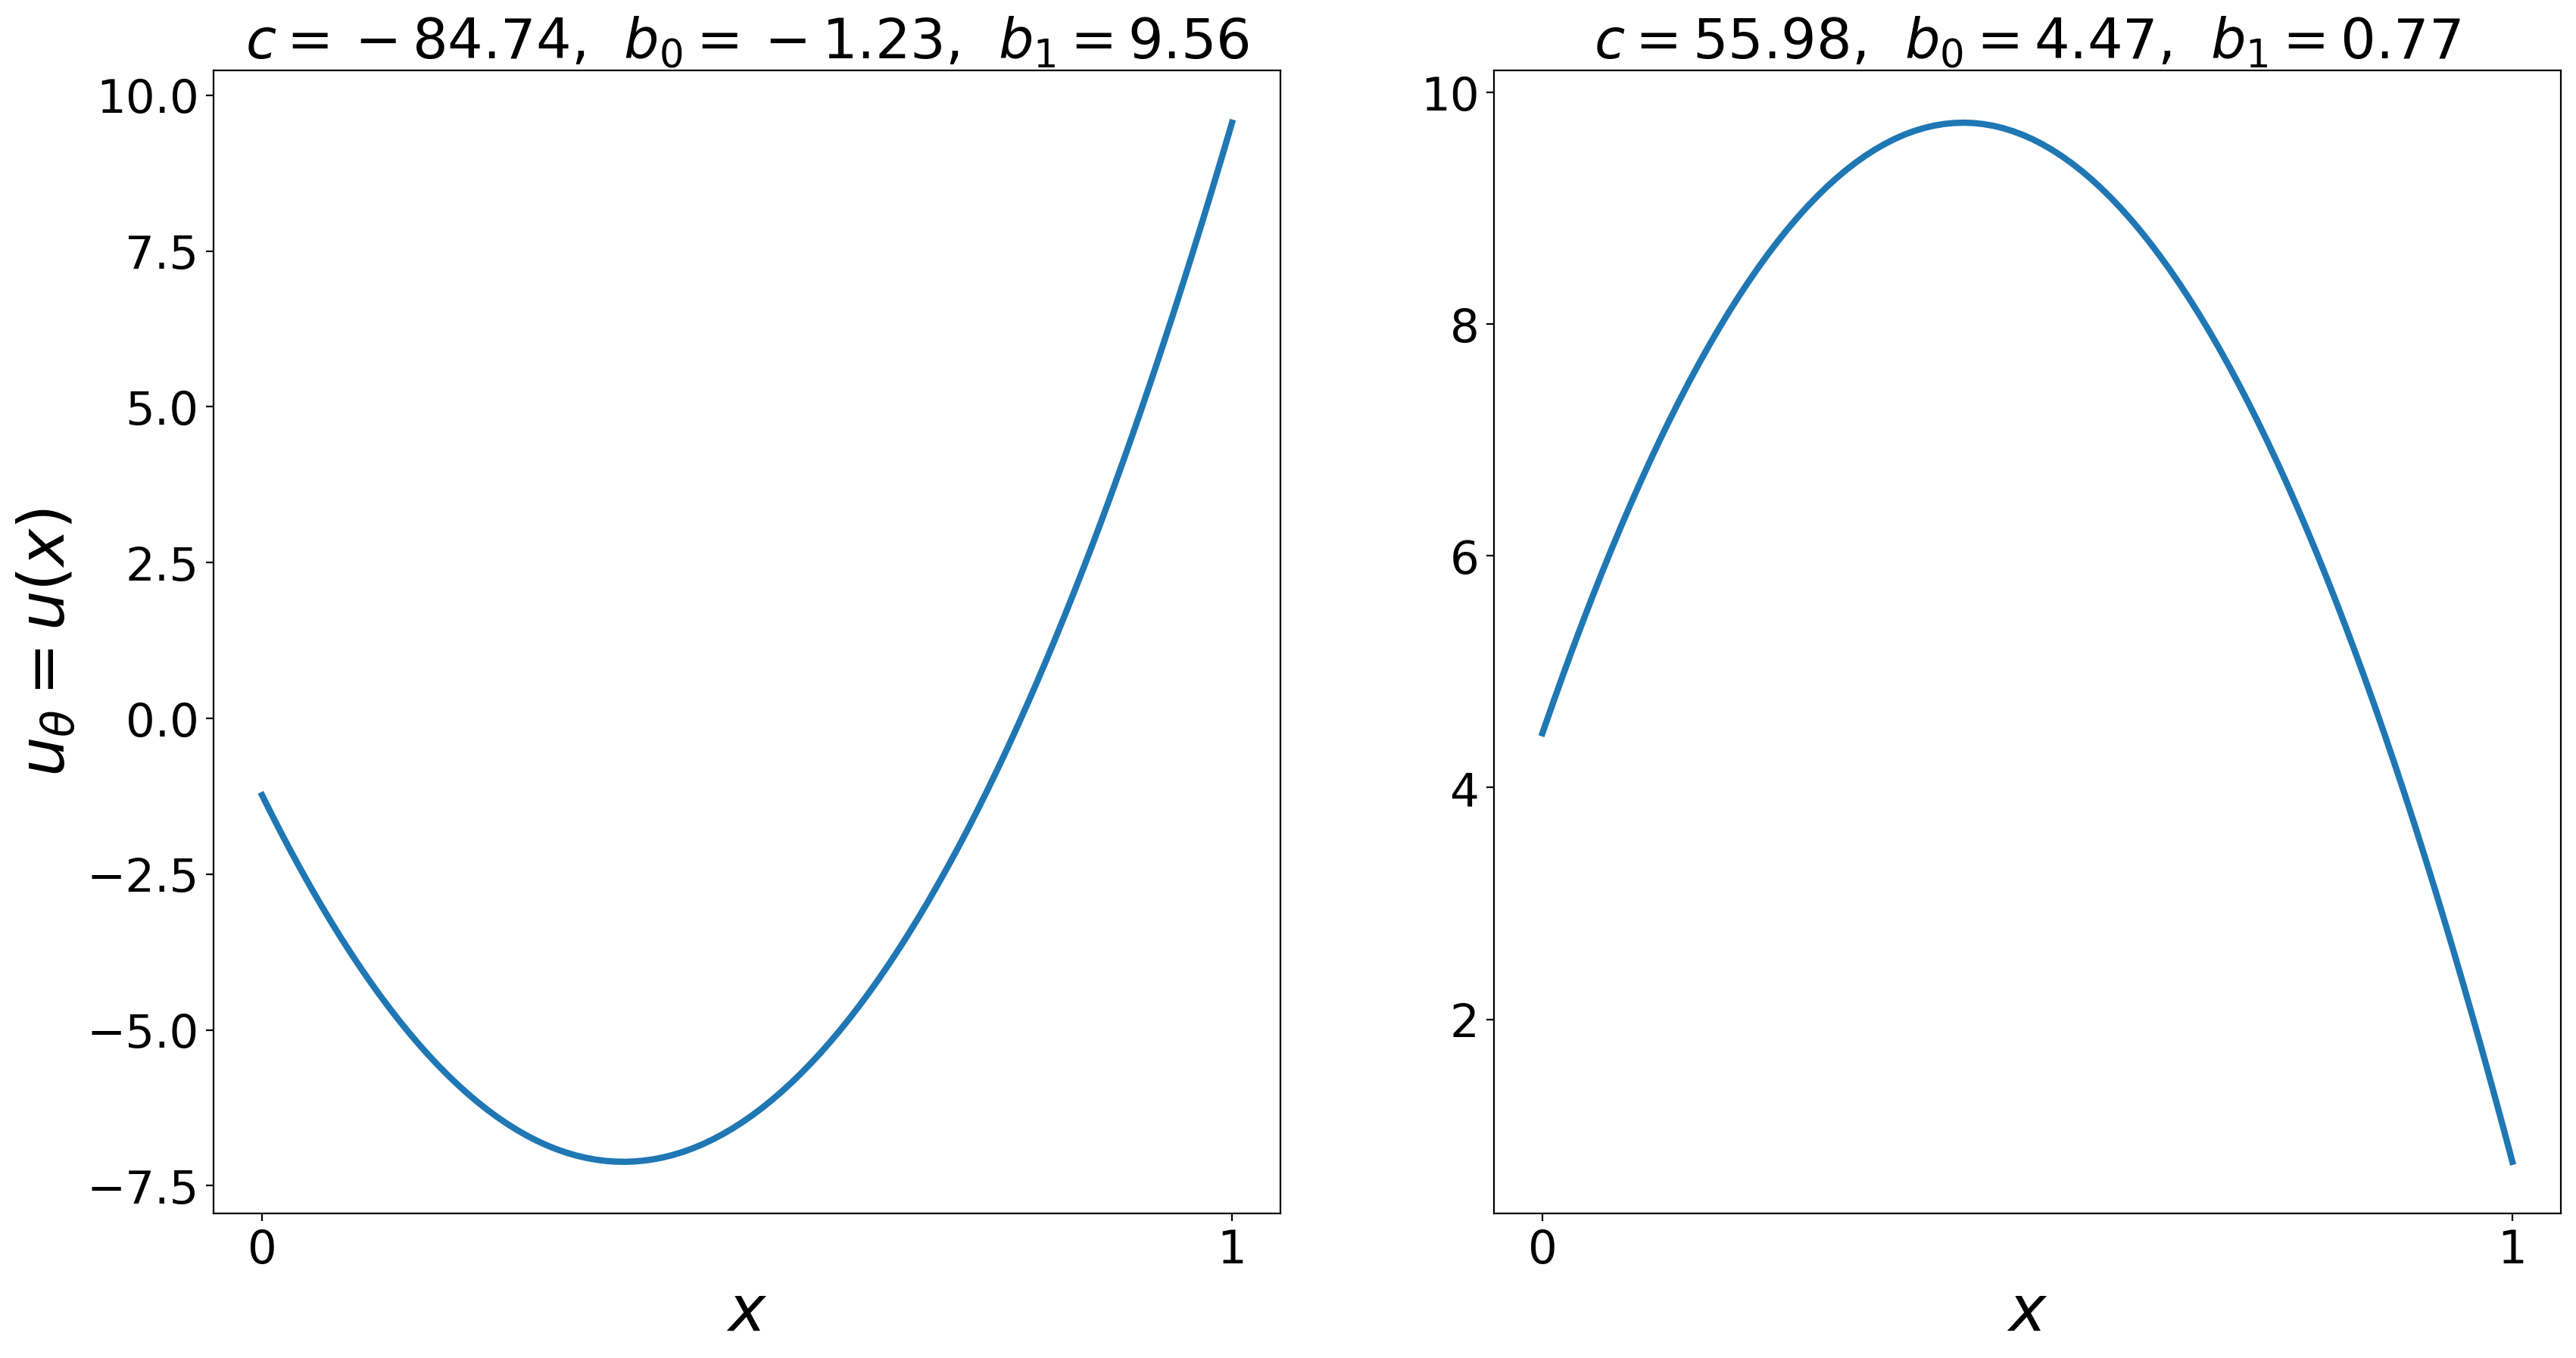

In [6]:
dataset.plot_solution()

Indeed, we can confirm the left and right endpoints 
of the above curves are given by $b_0$ and $b_1$, respectively.
Furthermore, the parameter $c$ measures the negative curvature
of the solutions, as is evident from the Poisson equation.

## 3. Design the neural net
Henceforth, we let $\Phi$ denote observed data that acts as inputs
to the neural net. The ground truth parameter is $\theta_\Phi$
while the parameters that are varying with the weights are $\theta$.
Thus, $u_\theta$ represents a reconstruction of $\Phi$.

Now that the data are loaded, we can design a neural network to train.
We will construct a feed-forward network with one hidden layer
containing 20 nodes. 
By default the data are rescaled to be in the interval $[-1, 1]$,
so $\tanh$ activations are a natural choice. Since this is a regression
task, the final layer will be activated with the identity function $f(x) = x$.
To avoid overfitting we'll drop 10% of the connections
between the hidden and final layer.
The optimizer and loss will be Adam and mean square error, respectively.
Let's train the network for 10 epochs using batch sizes of 25.

Conveniently, this is all recorded in a design dictionary below. 
Most keys make intuitive sense, but the `unit_activations` key
is perhaps more cryptic. It is a list of tuples, each tuple represents
the number of units and activation for each layer (in this case 2 layers).
We'll leave the callbacks list empty for now, but if we were training longer
we might decide to use a learning rate schedule or Tensorboard callbacks.

In [15]:
out_units = dataset.train[1].shape[1]

## DEFINE MODEL PARAMETERS
design = {'unit_activations':[(20, 'linear'),
                              (out_units, 'linear')
                             ],
          'dropout':[0.],
          'optimizer':'adam',
          'loss':'mse',
          'callbacks':[],
          'batch_size':25,
          'epochs':50,
         }

## 4. Train!

All that is left is to train the encoder.
We use the `Encoder` class from the module
`Poisson.encoder`,
which inherits from the `Sequential` class in Keras.
For reproducible results we'll set a seed in Tensorflow 
before training.

In [16]:
from Poisson.encoder import Encoder
from tensorflow.random import set_seed
set_seed(23) # for reproducibility

# TRAIN MODEL
model = Encoder(design, dataset)
model.train()

Model: "encoder_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 20)                2020      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 63        
Total params: 2,083
Trainable params: 2,083
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
48/48 - 0s - loss: 403.2946 - val_loss: 158.6404
Epoch 2/50
48/48 - 0s - loss: 71.7127 - val_loss: 18.7050
Epoch 3/50
48/48 - 0s - loss: 5.5669 - val_loss: 0.3624
Epoch 4/50
48/48 - 0s - loss: 0.0613 - val_loss: 9.0809e-04
Epoch 5/50
48/48 - 0s - loss: 8.3696e-04 - val_loss: 6.5023e-04
Epoch 6/50
48/48 - 0s - loss: 5.5945e-04 - val_loss: 4.6536e-04
Epoch 7/50
48/48 - 0s -

## 5. Assessing model fit
Great, training complete! Now let's see how the network performs
when predicting on a test set. We'll use the `Encoder.plot_theta_fit()`
method to predict on the test set, print the component-wise MSE, 
and plot the predictions against the ground truth.
Since $c$ and $b$ were simulated on different scales
we should compare them on a common scale by 
dividing by the max absolute value
of the predicted and true parameters.

theta MSE: [2.09877454e-11 4.94859154e-12 8.44962505e-12]
transformed theta MSE: [2.73890760e-15 5.17778366e-14 8.40558455e-14]


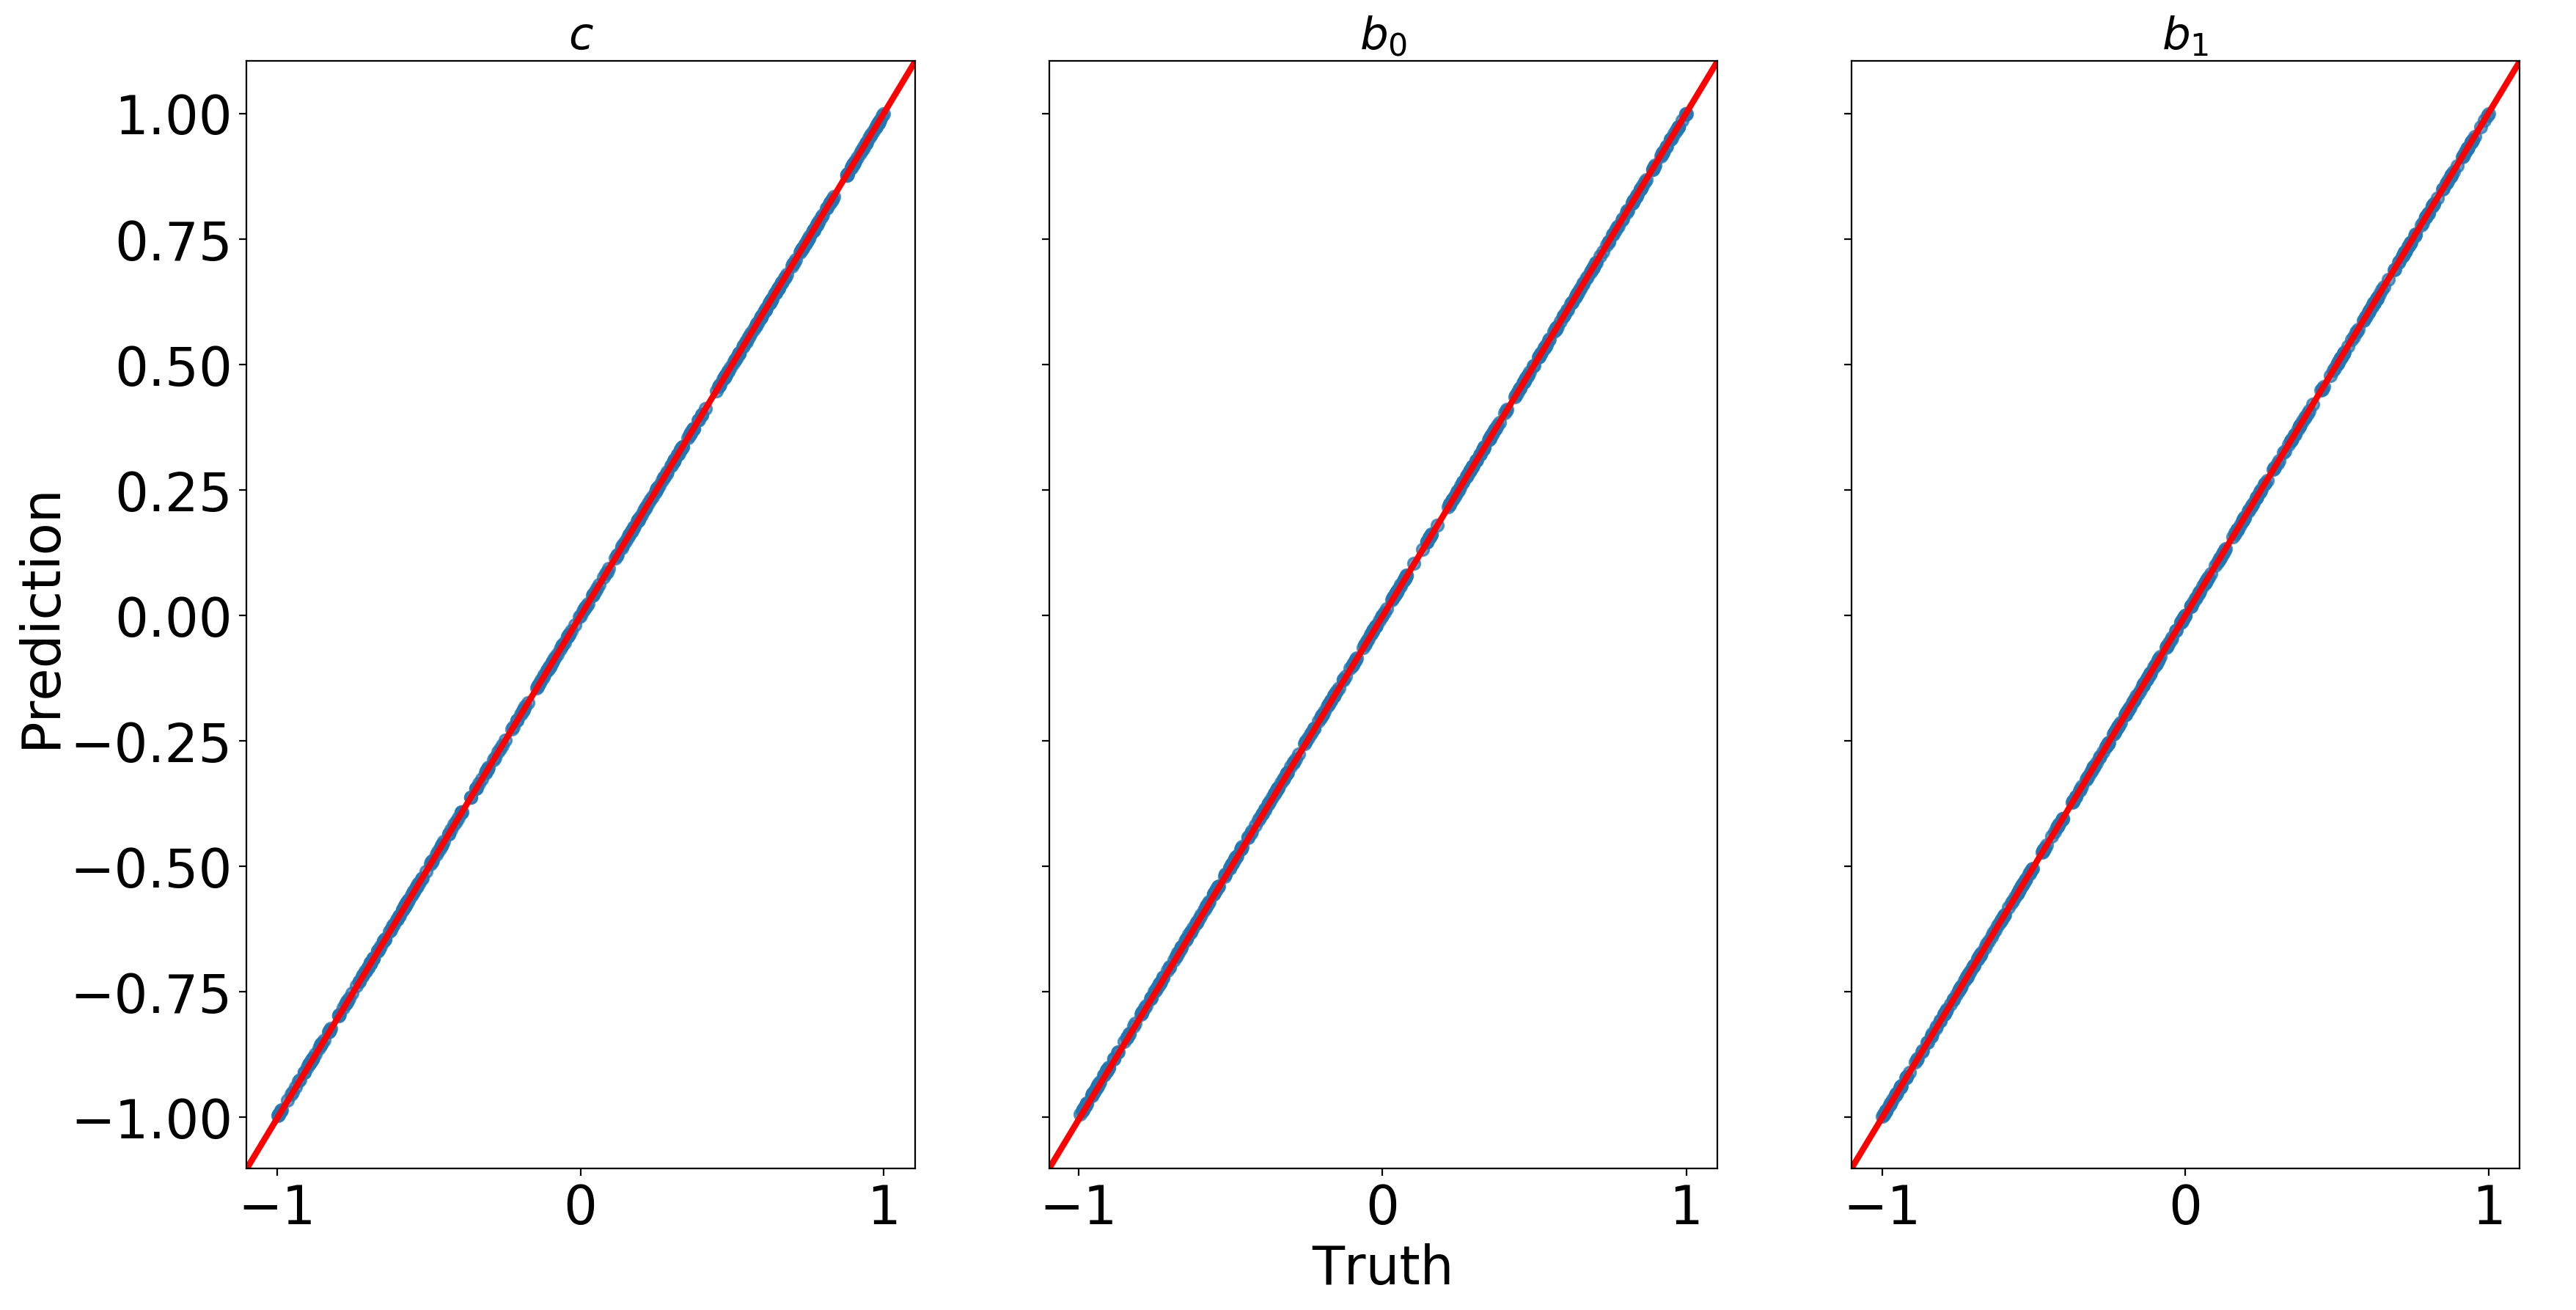

In [17]:
model.plot_theta_fit()

Not too shabby. Now let's see how the encoder performs
when we hand it noisy data. That is, we test it on
$\Phi + \varepsilon$ where 
$\varepsilon\sim\operatorname{Normal}(0,\sigma)$.

theta MSE: [11.75831024  2.52289369  2.18767186]
transformed theta MSE: [0.00138419 0.03363584 0.02991524]


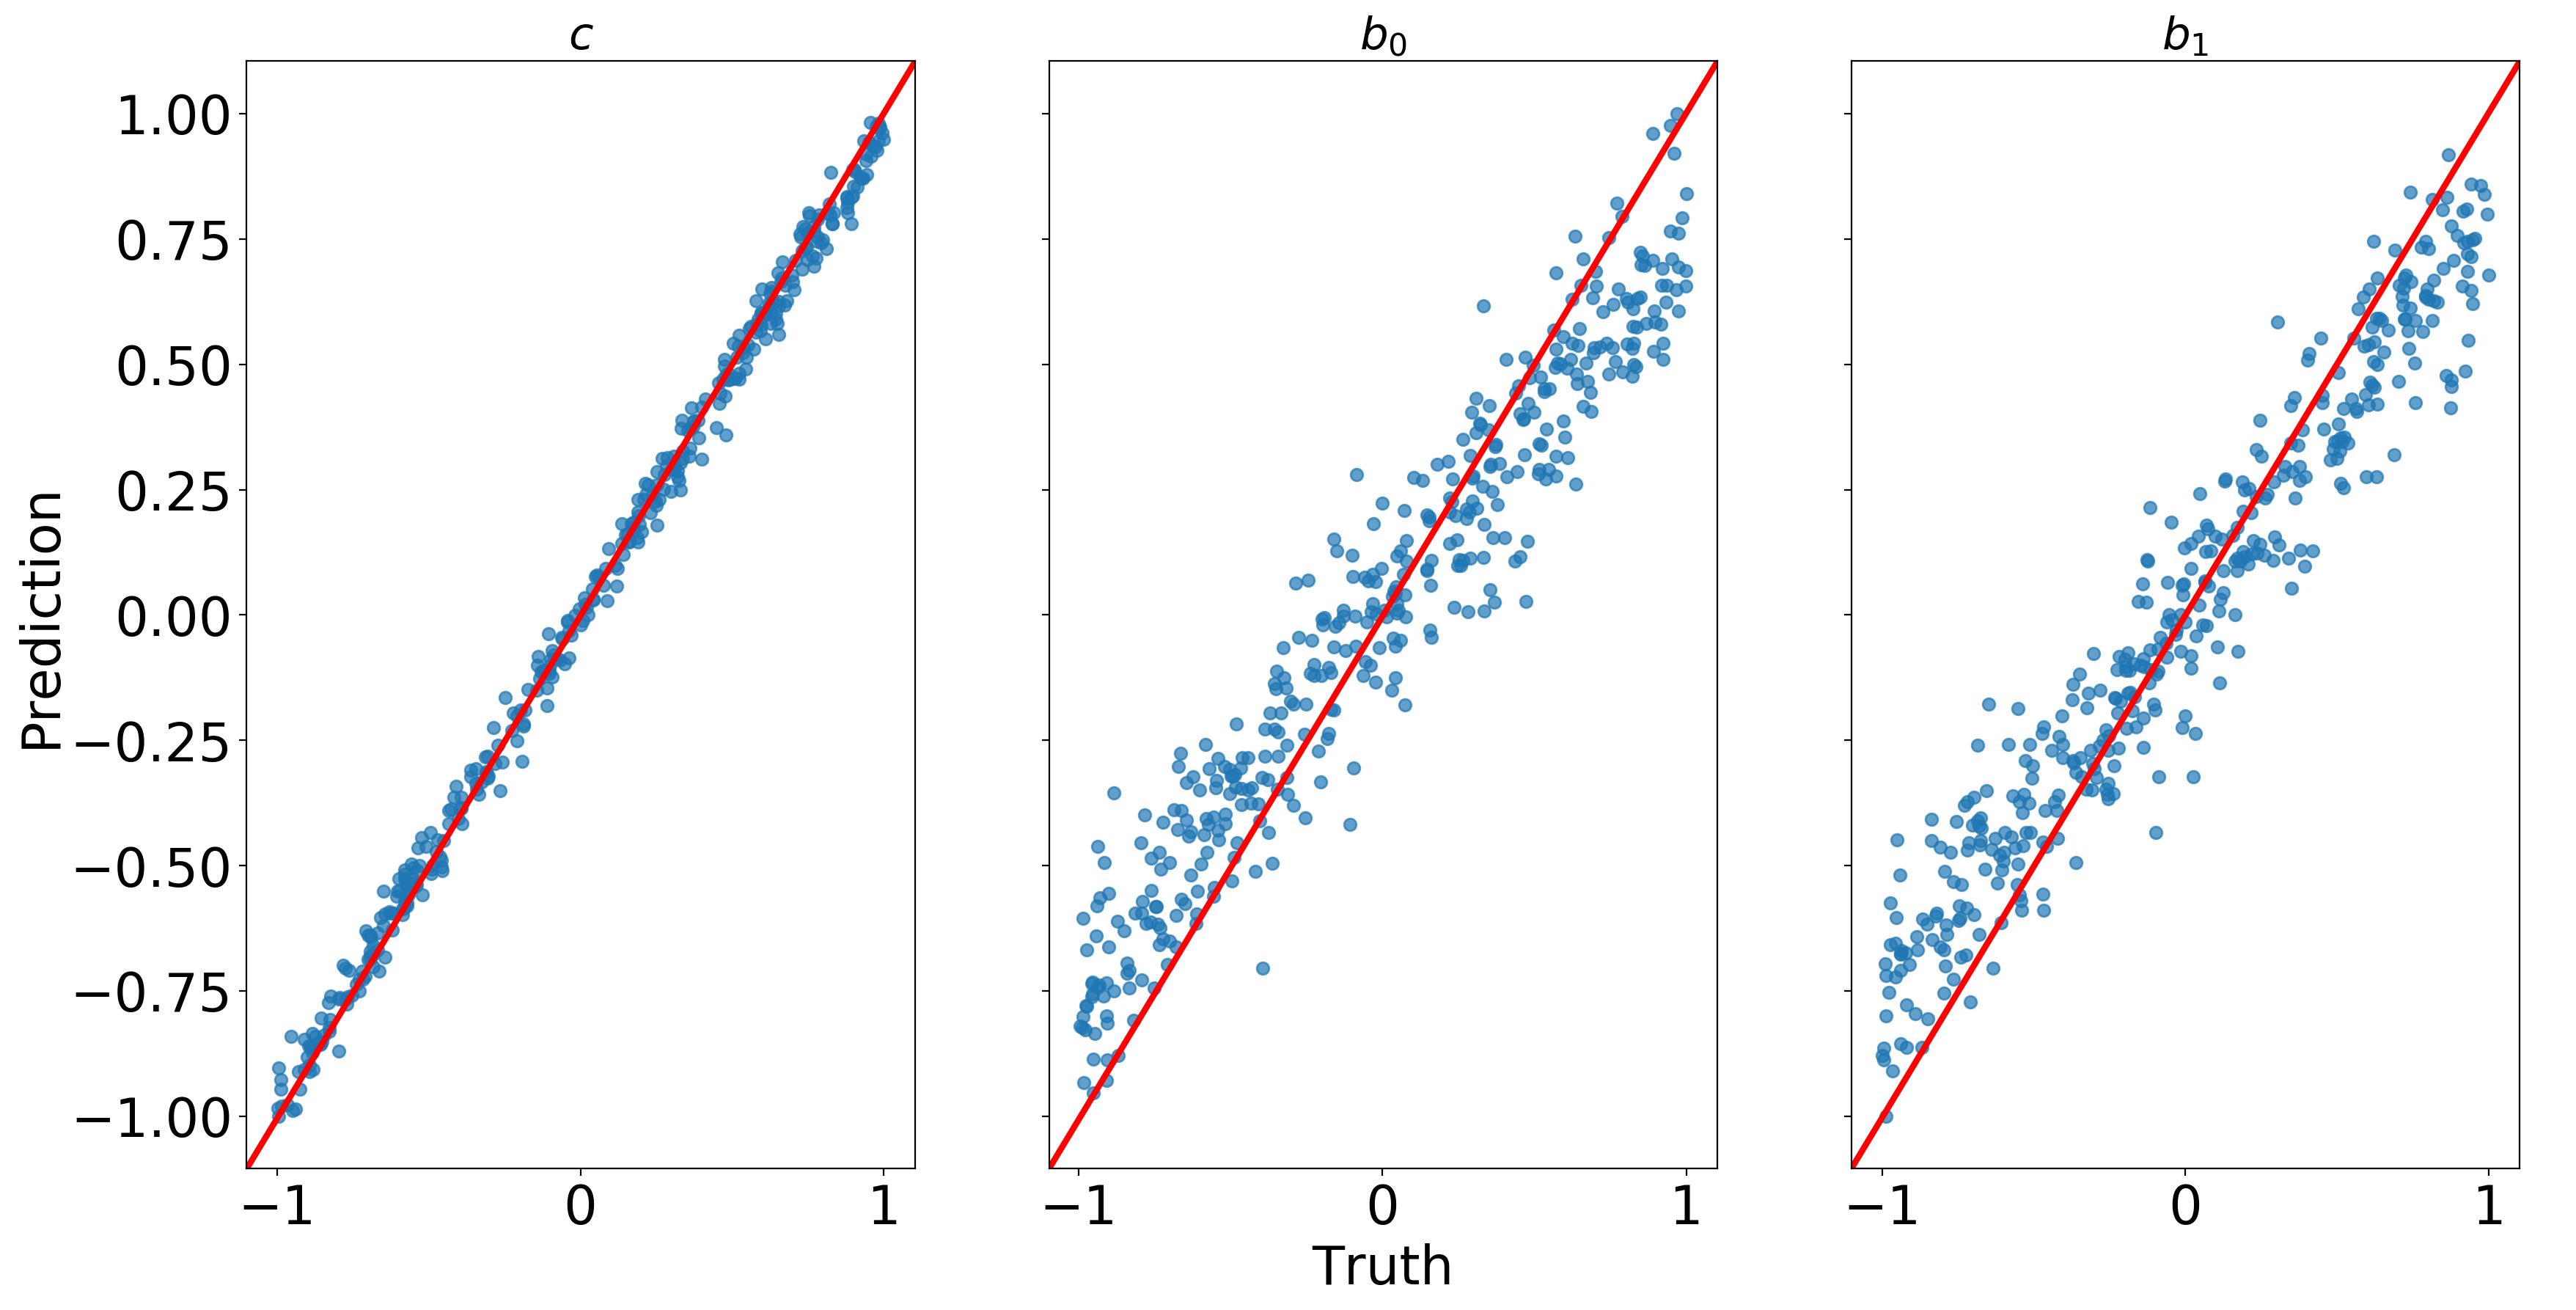

In [18]:
model.plot_theta_fit(sigma=1.0)

Since the purpose is to attach $\theta$ to a decoder
that outputs $u_{\theta}$, an approximation of $\Phi$, 
we should totally decode the predicted parameters
to produce the analytic solutions they give rise to.
As expected, we can see the true and predicted solutions are quite close.

Latent theta MSE: [2.09877454e-11 4.94859154e-12 8.44962505e-12]
Reconstructed Phi MSE: 5.123339068475058e-12


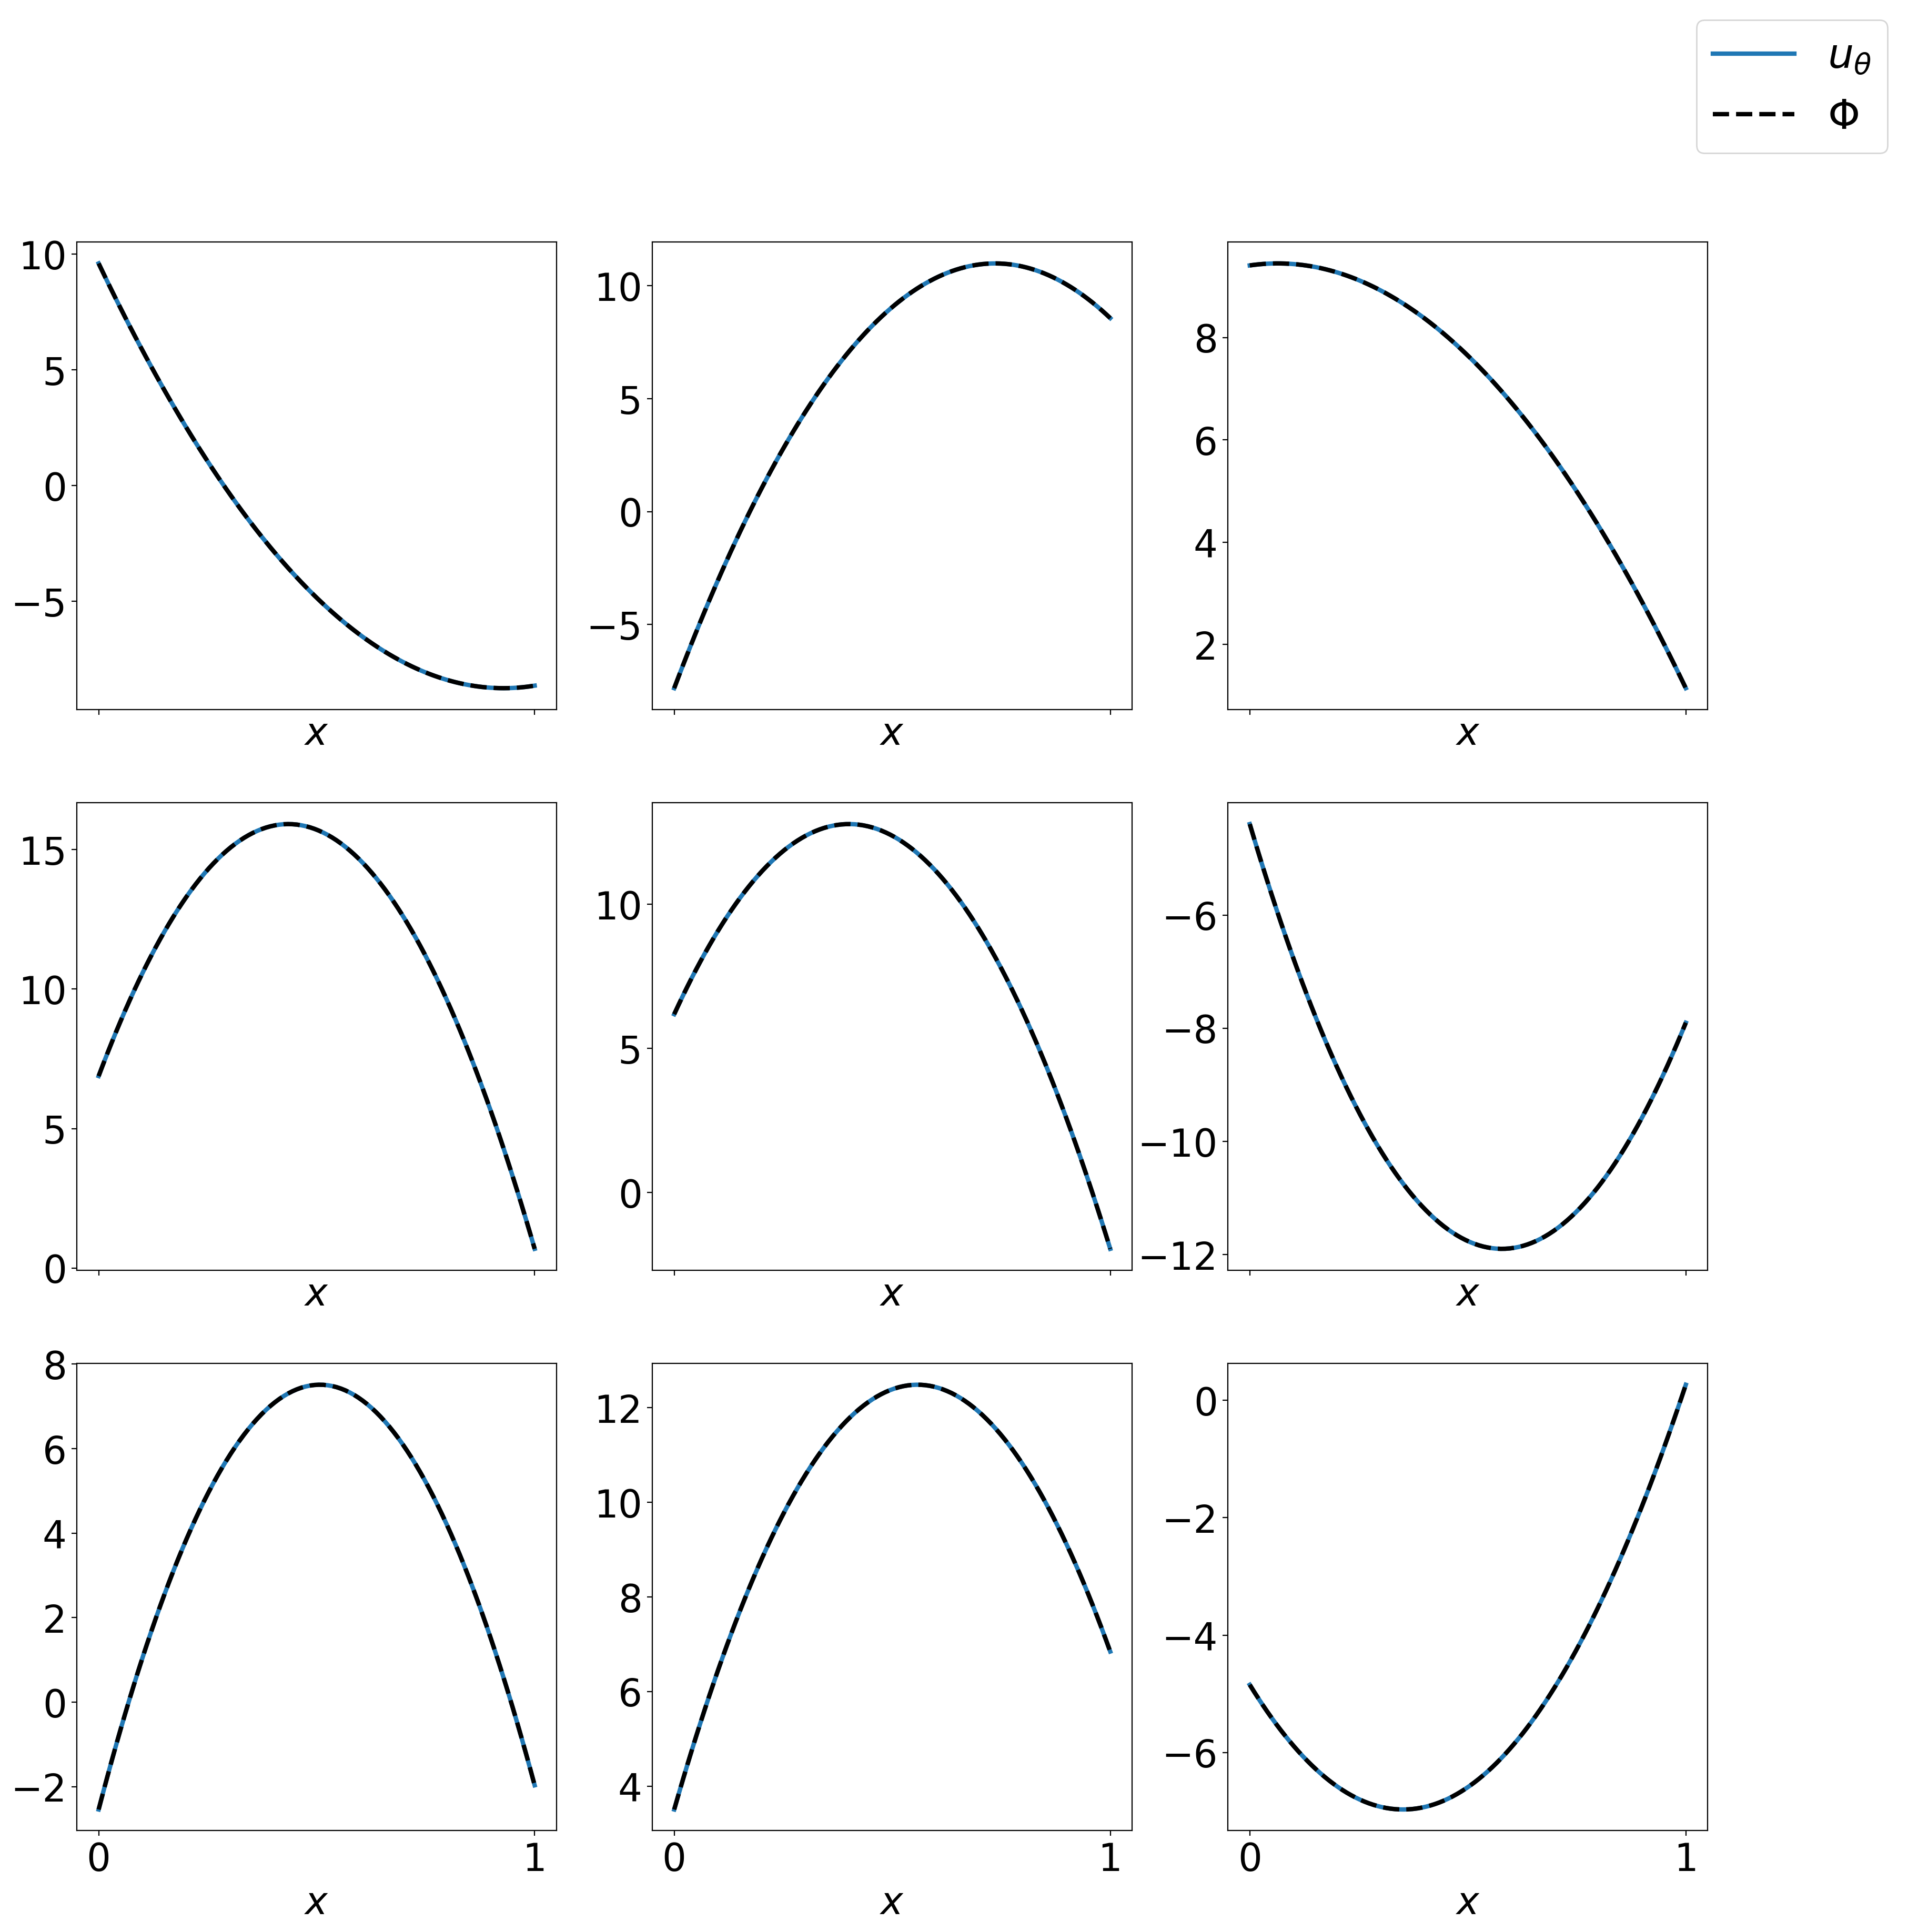

In [19]:
model.plot_solution_fit()

Looks pretty good. Just as before, let's see the solution
space fit when we hand the model $\Phi + \varepsilon$.

Latent theta MSE: [11.75831024  2.52289369  2.18767186]
Reconstructed Phi MSE: 2.714549625970907


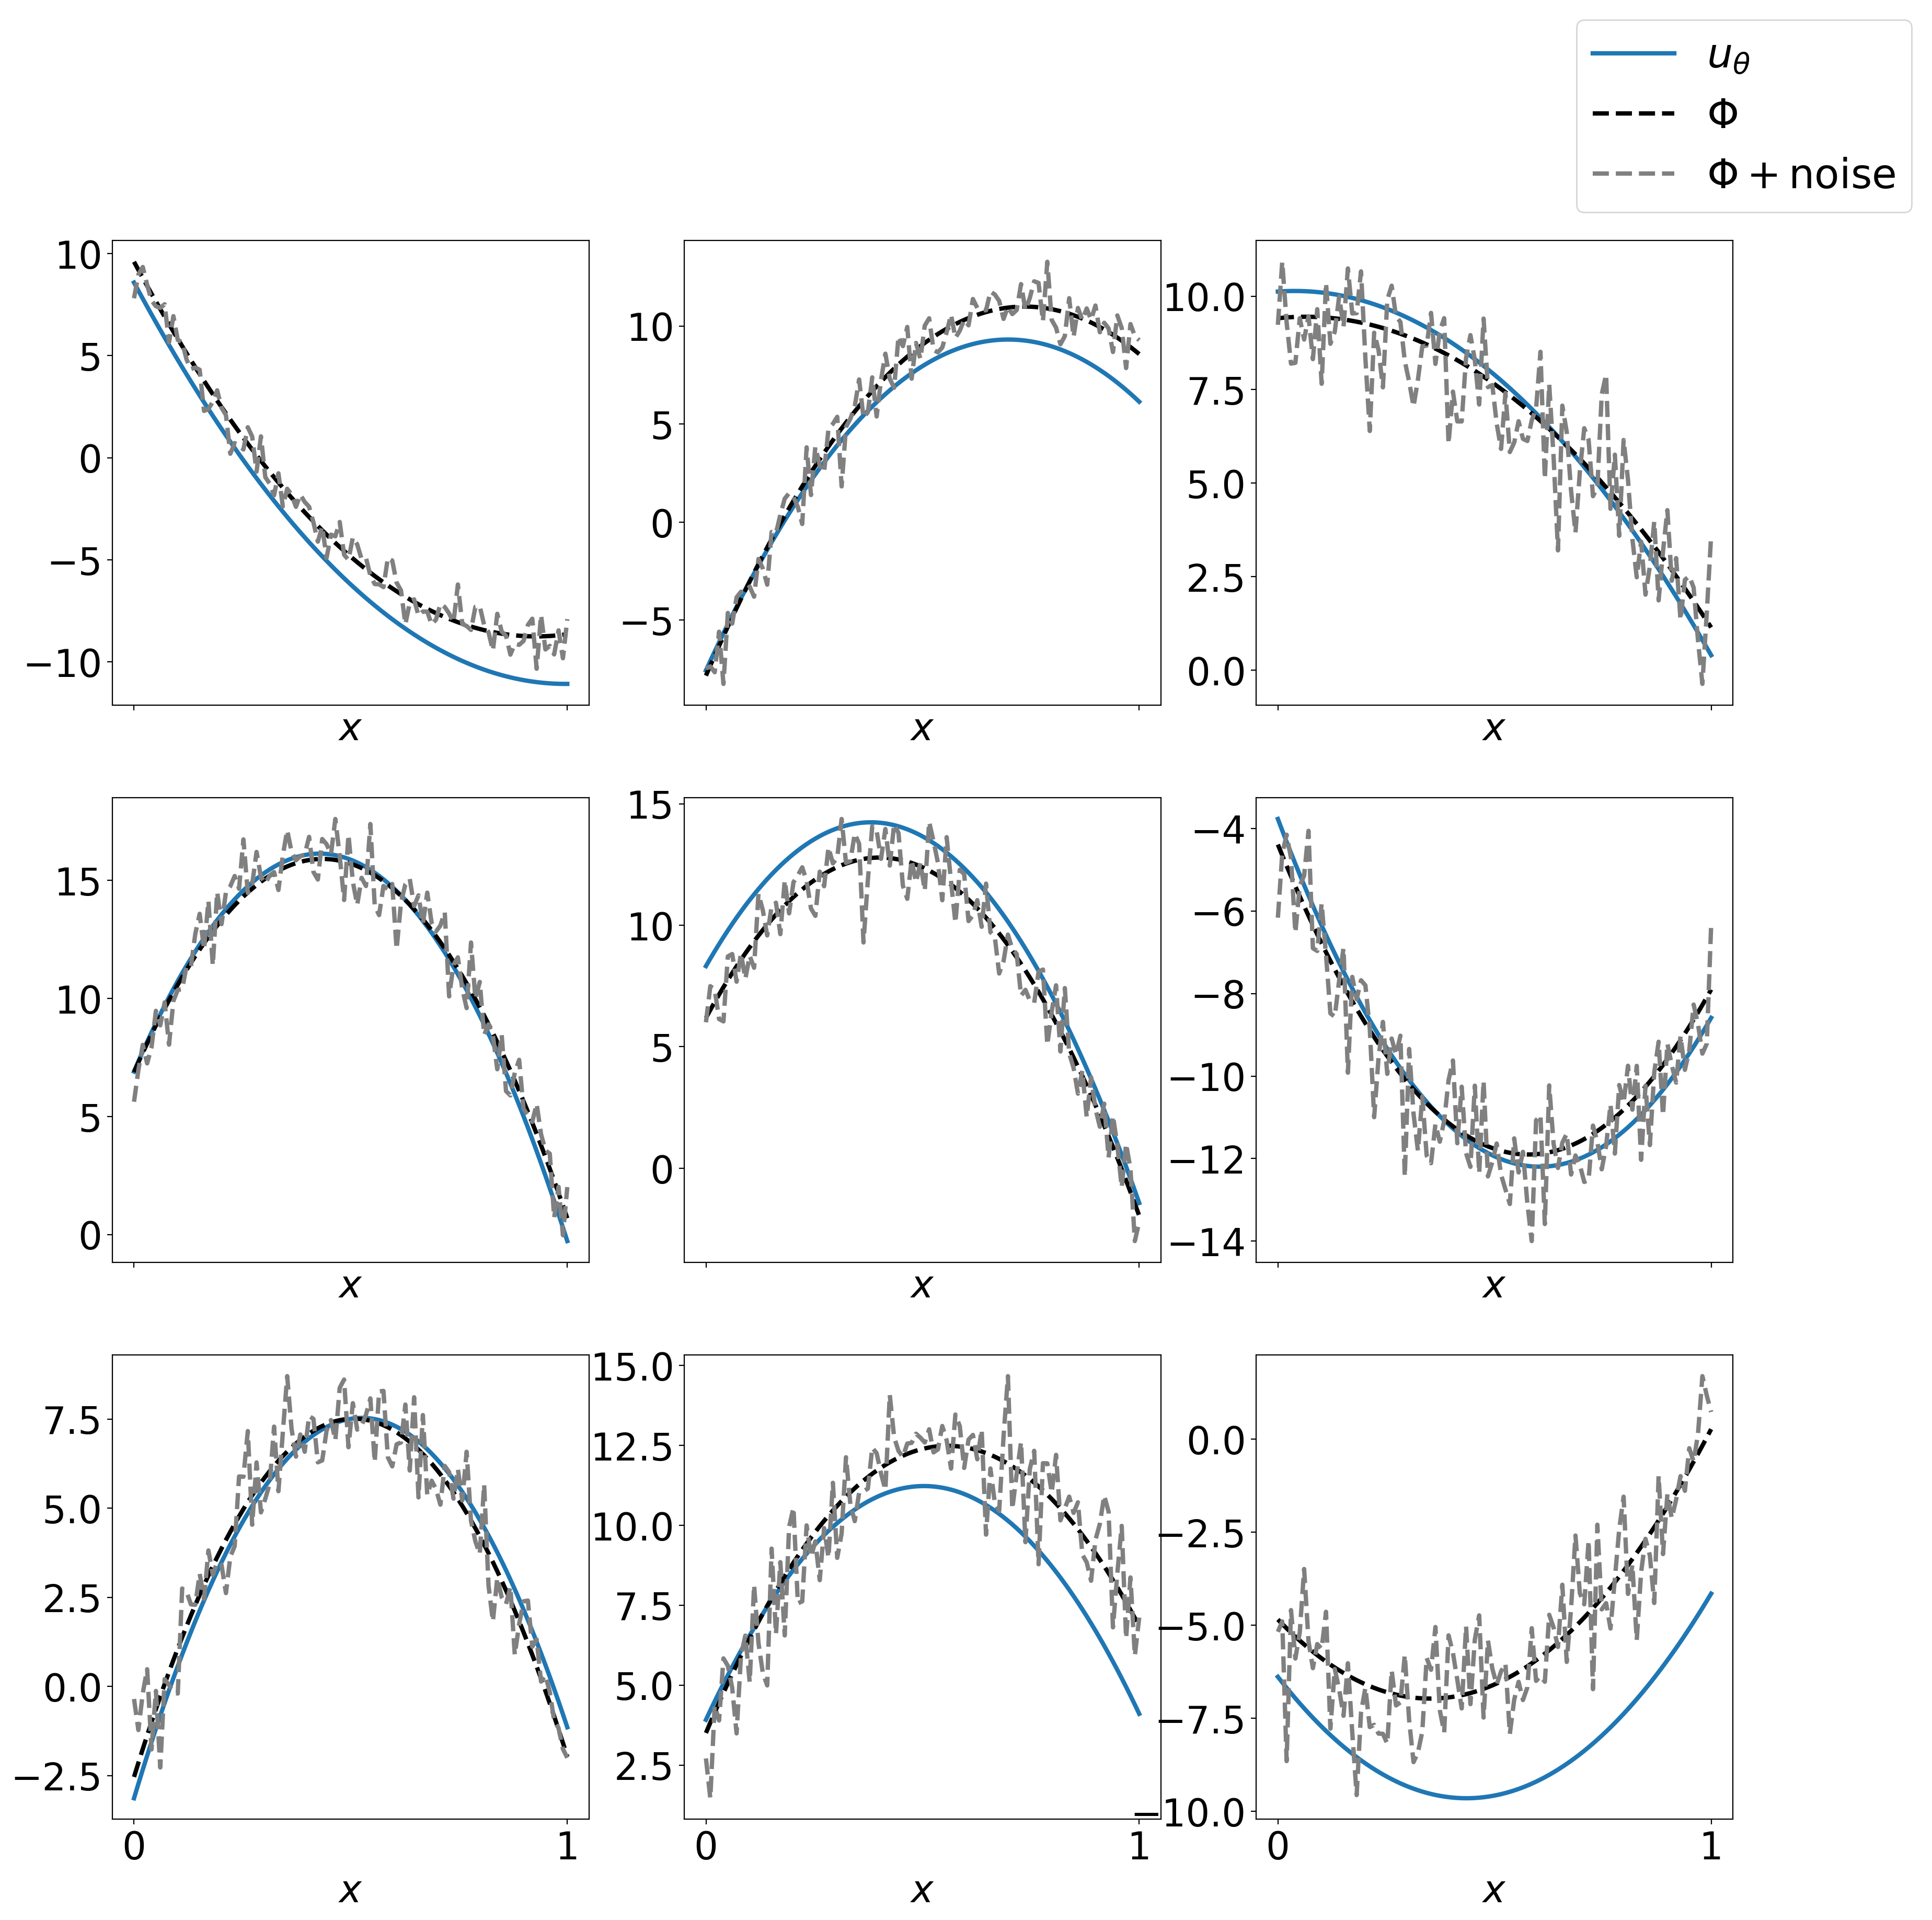

In [20]:
model.plot_solution_fit(sigma=1.0)